In [3]:
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 

In [4]:
fifty_coefficients_df = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv')
coefficients_df = pd.read_csv('./pivoted_model_coefficients_for_all_features.csv')

coefficients_df_cleaned = coefficients_df.dropna() 
originalDFSet = coefficients_df['County'].unique()
cleanedDF = coefficients_df_cleaned['County'].unique()

fifty_ds_cleaned = fifty_coefficients_df.dropna()
fifty_coefficients_df = fifty_coefficients_df['County'].unique()
fifty_ds_cleaned = fifty_ds_cleaned['County'].unique()

print(set(originalDFSet) - set(cleanedDF))
print(set(fifty_coefficients_df) - set(fifty_ds_cleaned))

{'Jeff Davis', 'Montgomery', 'Ben Hill', 'Bacon', 'Taliaferro', 'Jenkins'}
{'Sumter', 'Putnam', 'Baker', 'Glascock', 'Atkinson', 'Jones', 'Appling', 'Bulloch', 'Telfair', 'Calhoun', 'Jeff Davis', 'Lee', 'Laurens', 'Greene', 'Ben Hill', 'Quitman', 'Webster', 'Bacon', 'Towns', 'Dawson', 'Taliaferro', 'Clay', 'Cook', 'Chattooga', 'Monroe', 'Union', 'Stewart', 'Chattahoochee', 'Upson', 'Mitchell', 'Long', 'Heard', 'Lamar', 'Pike', 'Morgan', 'Stephens', 'Franklin', 'Montgomery', 'Dodge', 'Jasper', 'McIntosh', 'Jenkins'}


Visual Depiction of the Features vs. Counties TradeOff: 

- A **lower NaN threshold** (e.g., 30% or less):
  - I only include features in my analysis that have a relatively low proportion of missing values. This typically means that each feature I retain is more robustly represented across counties since there's sufficient data.
  - The result is that more counties can be included because I am only considering features that these counties have enough data for.
  - However, I'll have fewer features to analyze because I've excluded those with higher amounts of missing data.

- A **higher NaN threshold** (e.g., 50% or less):
  - I've included features with a higher proportion of missing values. This allows me to retain a larger number of features for your analysis.
  - The drawback is that some counties may not have enough data to be included for these additional features, which leads to their exclusion from the analysis.
  - This can result in a dataset with more features but fewer counties.



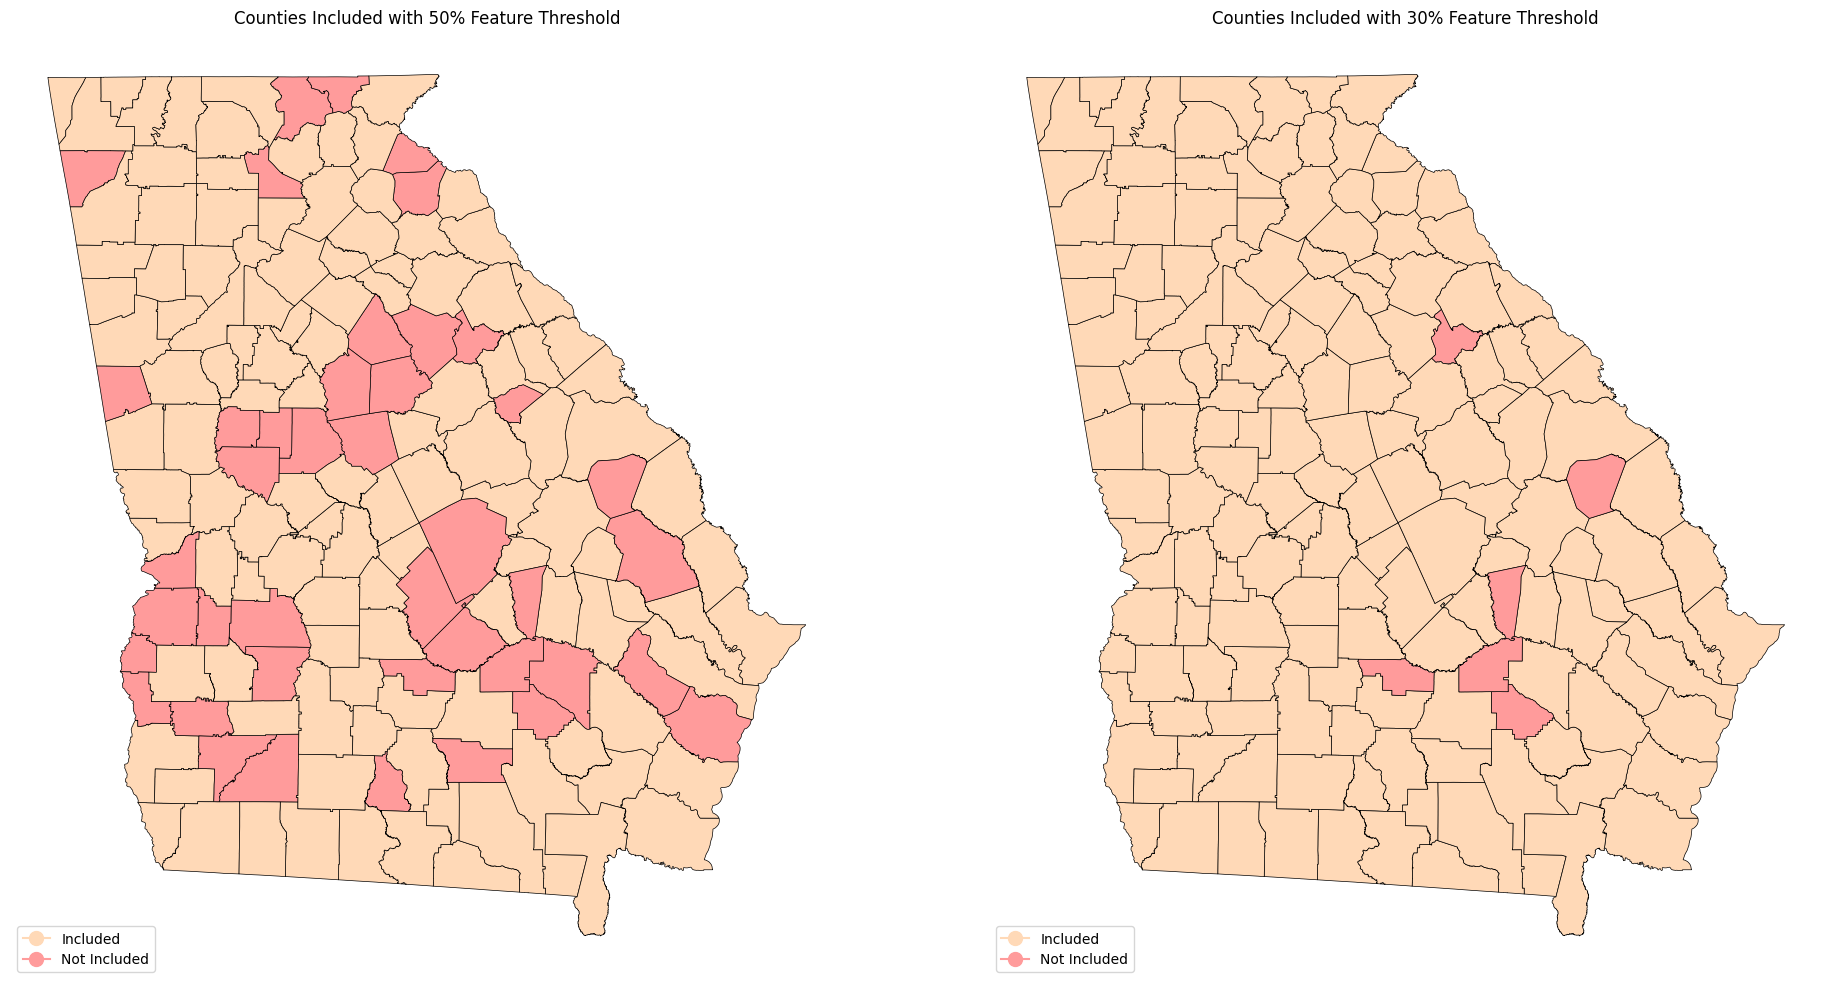

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load datasets
cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")
coefficients_50_threshold = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv').dropna()
coefficients_30_threshold = pd.read_csv('pivoted_model_coefficients_for_all_features.csv').dropna()

# GeoDataFrame of the Georgia counties shapefile
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Flags for whether counties are included based on the number of features meeting the threshold
geo_data['included_50_threshold'] = geo_data['NAME10'].isin(coefficients_50_threshold['County'].unique()).astype(int)
geo_data['included_30_threshold'] = geo_data['NAME10'].isin(coefficients_30_threshold['County'].unique()).astype(int)

# Define color mappings (pastel blue for included, pastel green for not included)
color_map = {0: '#FFD9B7', 1: '#FF9B9B'} 

# Manual legend elements for the custom labels without scale
legend_elements = [
    Line2D([0], [0], marker='o', color=color_map[0], label='Included', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[1], label='Not Included', markerfacecolor=color_map[1], markersize=10),
]

# Create maps to show included counties for each threshold
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# 50% Threshold map
geo_data.plot(column='included_50_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_50_threshold'].unique()]),
              ax=axs[0], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[0].set_title('Counties Included with 50% Feature Threshold')
axs[0].axis('off')
axs[0].legend(handles=legend_elements, loc='lower left')

# 30% Threshold map
geo_data.plot(column='included_30_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_30_threshold'].unique()]),
              ax=axs[1], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[1].set_title('Counties Included with 30% Feature Threshold')
axs[1].axis('off')
axs[1].legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


First Step: Visualizations and Principal Component Analysis 

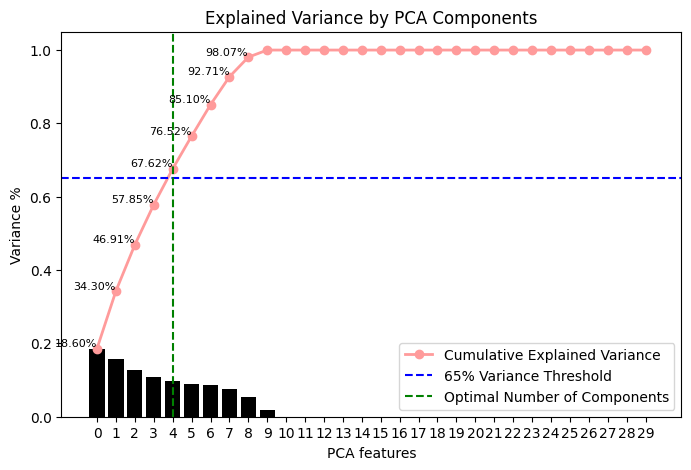

Number of components to explain 65.0% variance: 5


In [306]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values
variance_threshold = 0.65  # Setting the threshold to 65%

# Fit PCA and plot the individual explained variance
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Explained Variance by PCA Components')

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance trend line
plt.plot(features, cumulative_variance, color='#FF9B9B', marker='o', linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Annotate the points for the first 9 features or until cumulative variance reaches 100%
for i, v in enumerate(cumulative_variance):
    if v < 1.0 and i < 9:  # Check if the cumulative variance is less than 100% and within the first 9 features
        plt.text(i, v, f"{v:.2%}", fontsize=8, ha='right', va='bottom')

# Add a horizontal line at the 65% variance threshold
plt.axhline(y=variance_threshold, color='blue', linestyle='--', label='65% Variance Threshold')

# Find the number of components for the desired threshold and add a vertical line at this point
components_for_threshold = np.argmax(cumulative_variance >= variance_threshold) + 1
plt.axvline(x=components_for_threshold-1, color='green', linestyle='--', label='Optimal Number of Components')

# Show the plot with legends
plt.legend()
plt.show()

# Print the number of components required to explain the desired threshold of variance
print(f"Number of components to explain {variance_threshold*100}% variance: {components_for_threshold}")


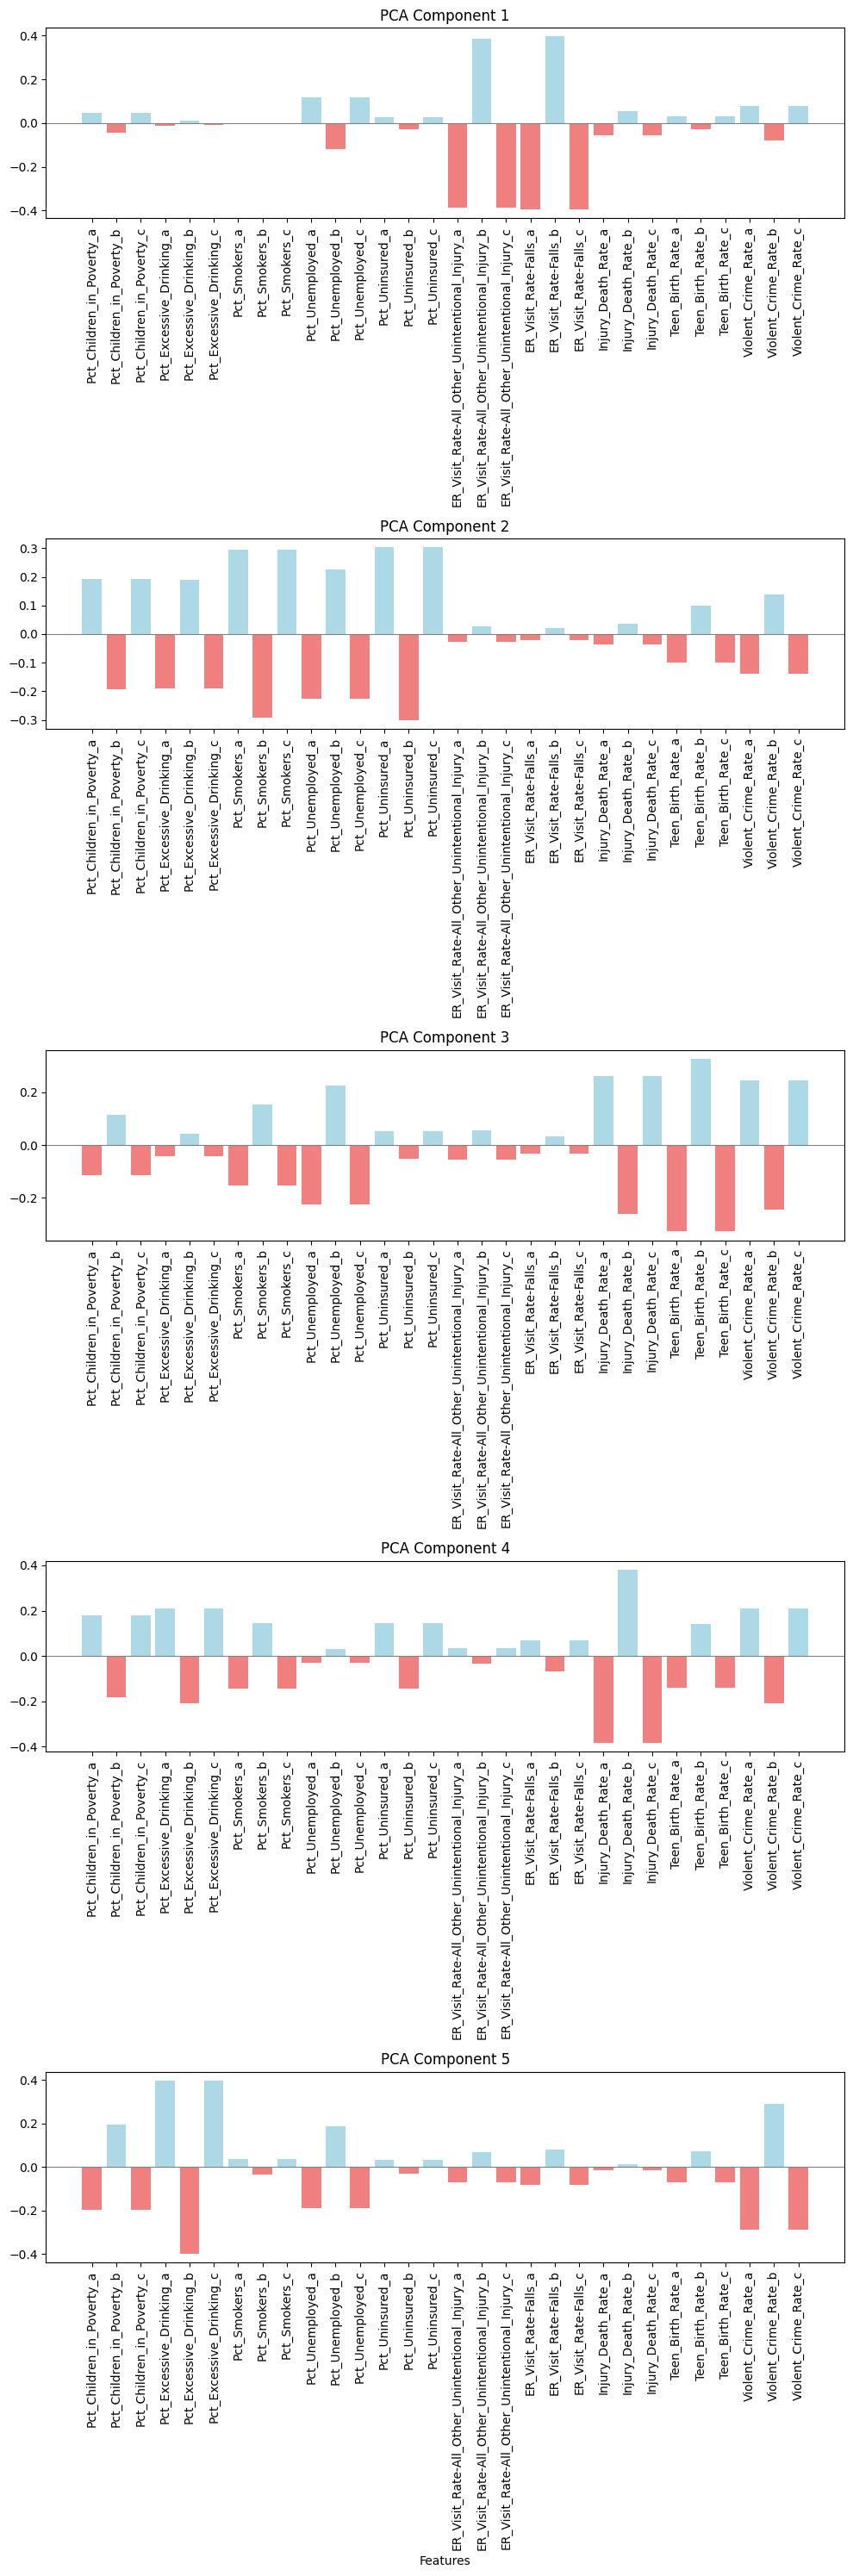

In [312]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your dataset and 'features' contains your feature names
features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Get loadings
loadings = pca.components_

# Create a figure with subplots for each PCA component
fig, axs = plt.subplots(5, 1, figsize=(10, 30))  # Adjust the size as needed

# Plot each PCA component's loadings
for i in range(5):
    loading_values = loadings[i, :]
    bar_colors = ['lightblue' if x > 0 else 'lightcoral' for x in loading_values]
    bars = axs[i].bar(features, loading_values, color=bar_colors)
    axs[i].set_title(f'PCA Component {i+1}')
    axs[i].set_xticks(range(len(features)))
    axs[i].set_xticklabels(features, rotation=90)  # Rotate the feature names for better visibility
    axs[i].axhline(0, color='grey', linewidth=0.8)

# Set the xlabel for the last subplot
axs[-1].set_xlabel('Features')

plt.tight_layout()
plt.show()


In [317]:
import pandas as pd
from sklearn.decomposition import PCA

# Let's say 'X' is your dataset and 'features' is the list of column names
pca = PCA(n_components=5)
pca.fit(X)

# Create a DataFrame with the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PCA Component #{i+1}' for i in range(5)], index=features)

# Function to map each feature to its most contributing PCA component
def map_features_to_components(loadings_df):
    feature_component_map = {}
    for feature in loadings_df.index:
        dominant_component = loadings_df.loc[feature].abs().idxmax()
        if dominant_component in feature_component_map:
            feature_component_map[dominant_component].append(feature)
        else:
            feature_component_map[dominant_component] = [feature]
    return feature_component_map

# Map the features to components
features_mapped_to_components = map_features_to_components(loadings)

# Print the mapping
for component, features_list in features_mapped_to_components.items():
    print(f"{component} key features: {', '.join(features_list)}")


PCA Component #5 key features: Pct_Children_in_Poverty_a, Pct_Children_in_Poverty_b, Pct_Children_in_Poverty_c, Pct_Excessive_Drinking_a, Pct_Excessive_Drinking_b, Pct_Excessive_Drinking_c, Violent_Crime_Rate_a, Violent_Crime_Rate_b, Violent_Crime_Rate_c
PCA Component #2 key features: Pct_Smokers_a, Pct_Smokers_b, Pct_Smokers_c, Pct_Uninsured_a, Pct_Uninsured_b, Pct_Uninsured_c
PCA Component #3 key features: Pct_Unemployed_a, Pct_Unemployed_b, Pct_Unemployed_c, Teen_Birth_Rate_a, Teen_Birth_Rate_b, Teen_Birth_Rate_c
PCA Component #1 key features: ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_b, ER_Visit_Rate-Falls_c
PCA Component #4 key features: Injury_Death_Rate_a, Injury_Death_Rate_b, Injury_Death_Rate_c


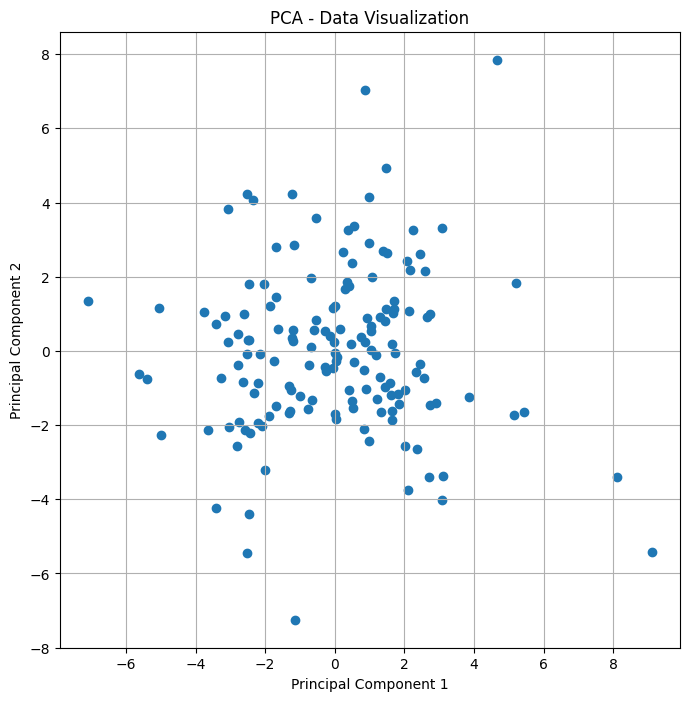

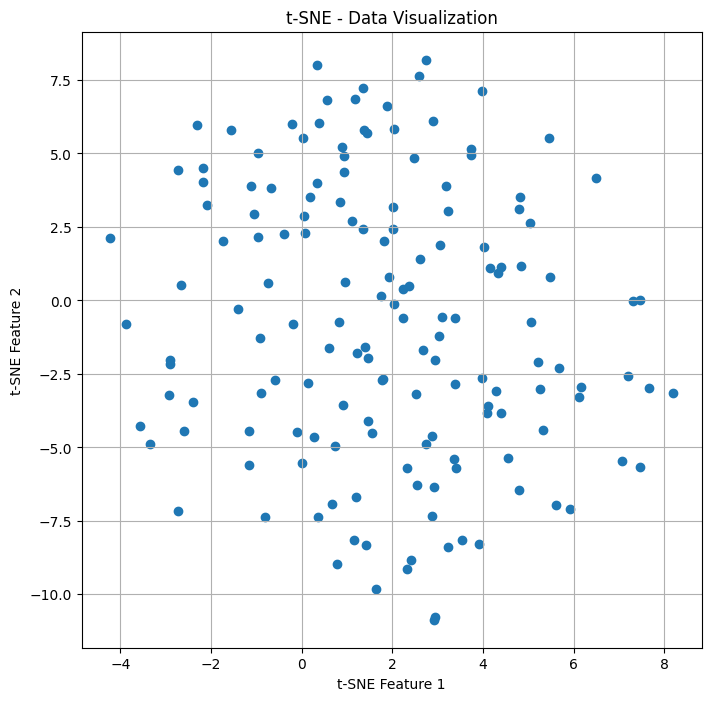

In [193]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming coefficients_df_cleaned is your DataFrame with features you want to plot
features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Initialize PCA and transform your data to the first two principal components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the PCA result
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA - Data Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

from sklearn.manifold import TSNE

# Initialize t-SNE and transform your data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE result
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE - Data Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()




Second Step: Clustering 

Determined the optimal number of clusters using nbclust package: R, elbow method, sillhouette scores graph 

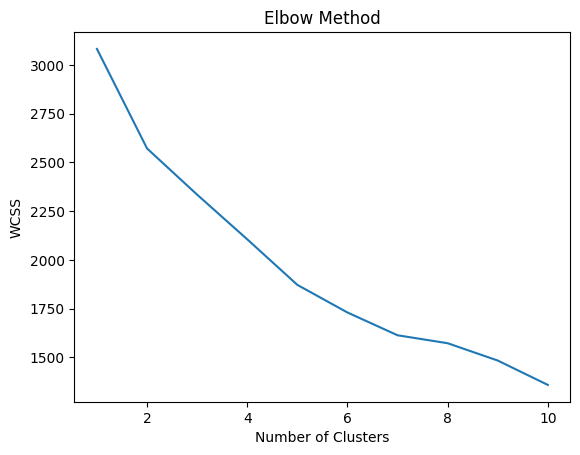

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')
#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show() 

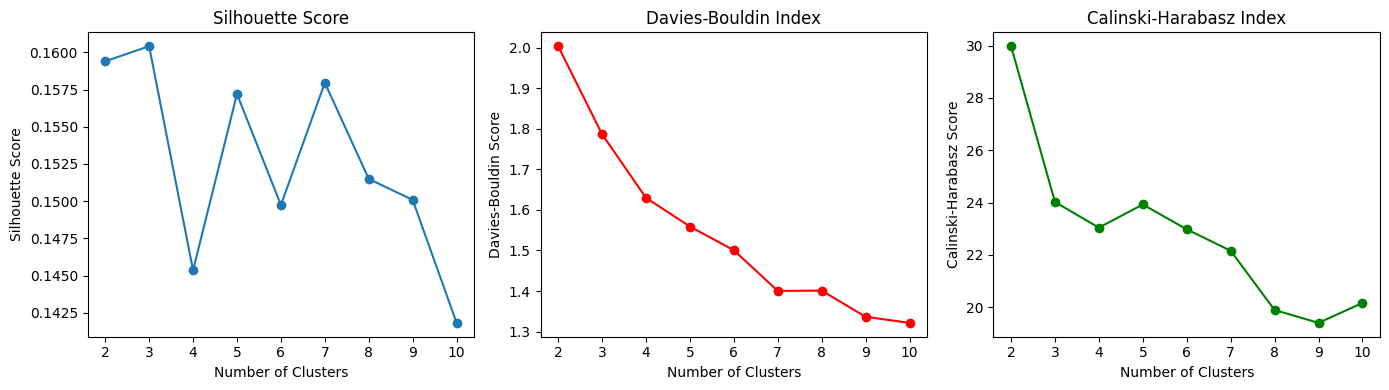

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X = X_pca

# Prepare lists to store the scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Range of cluster numbers to try
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute the metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    davies_bouldin = davies_bouldin_score(X, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

    # Store the scores
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

# Plot the Silhouette Score
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel("Silhouette Score")

# Plot the Davies-Bouldin Index (remember, for this metric, lower is better)
plt.subplot(132)
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o', color='r')
plt.title("Davies-Bouldin Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Davies-Bouldin Score")

# Plot the Calinski-Harabasz Index
plt.subplot(133)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o', color='g')
plt.title("Calinski-Harabasz Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_11009/1691128283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


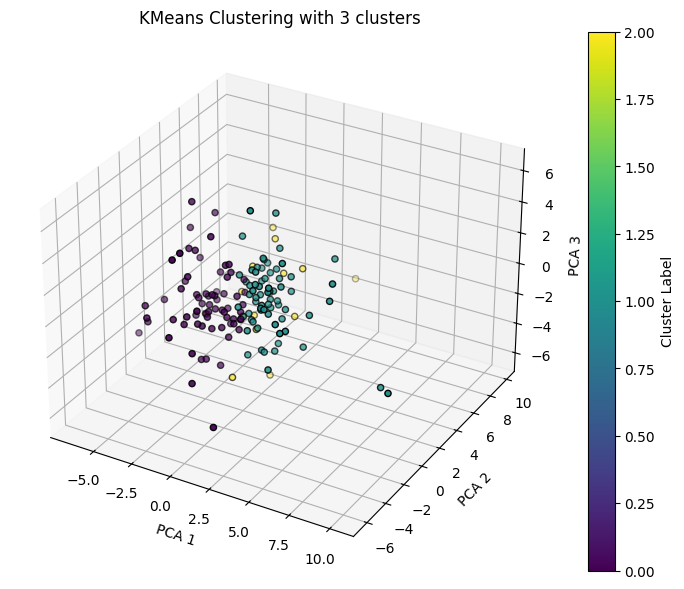

In [50]:
from sklearn.cluster import KMeans


coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

n_clusters = 3

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels


from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 3 clusters')

plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_11009/2777442171.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


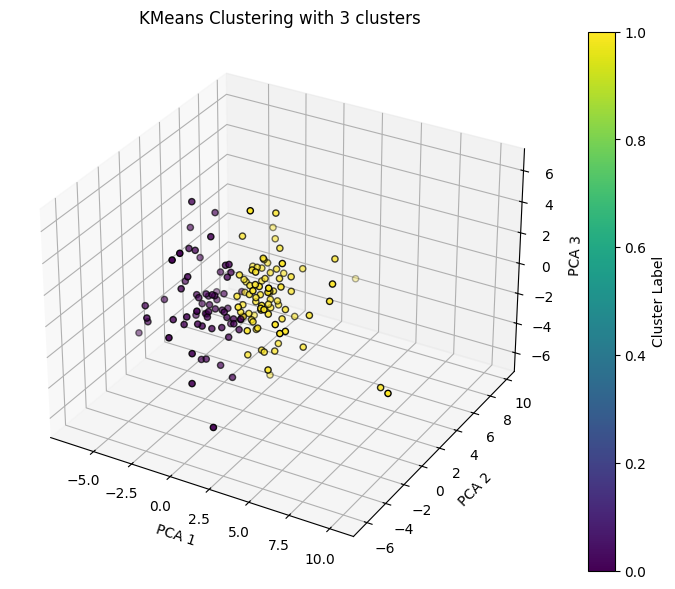

In [98]:
from sklearn.cluster import KMeans


coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

n_clusters = 2

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 3 clusters')

plt.show()



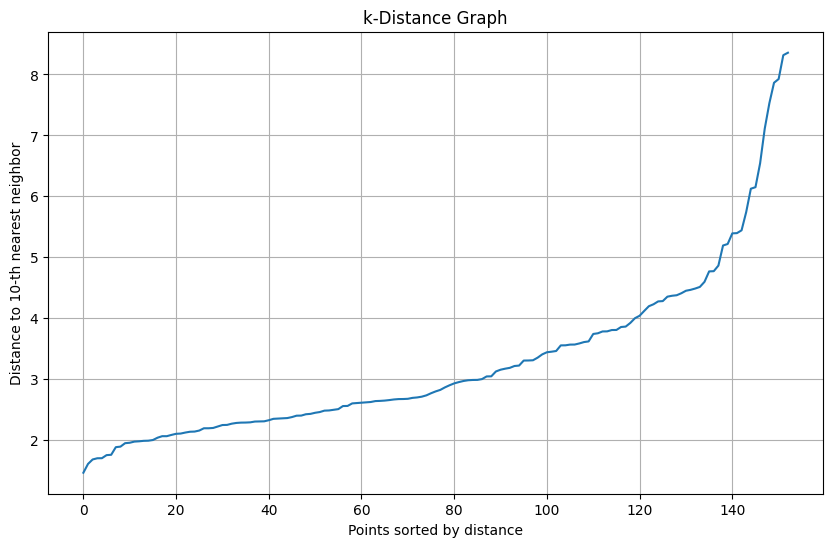

In [54]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_pca is your dataset after PCA reduction to 5 components
X = X_pca

# Choose k = min_samples - 1 (assuming you're starting with min_samples = 2*dim for PCA with 5 components)
k = 10
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)

# Sort the distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.title('k-Distance Graph')
plt.grid(True)
plt.show()


In [70]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Assuming X_pca is your PCA-reduced dataset
X = X_pca

# Define ranges for eps with step size of 0.5
eps_values = np.arange(1, 10, 0.1)
min_samples_values = range(2, 25)  # 2 * numDimensions

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'eps': None, 'min_samples': None}
best_davies_bouldin = {'score': np.inf, 'eps': None, 'min_samples': None}
best_calinski_harabasz = {'score': -1, 'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)

        # Skip if only one cluster is found or all points are considered noise
        if len(np.unique(clusters)) < 2 or (clusters == -1).all():
            continue

        # Calculate metrics
        silhouette = silhouette_score(X, clusters)
        davies_bouldin = davies_bouldin_score(X, clusters)
        calinski_harabasz = calinski_harabasz_score(X, clusters)

        # Update best silhouette score
        if silhouette > best_silhouette['score']:
            best_silhouette['score'] = silhouette
            best_silhouette['eps'] = eps
            best_silhouette['min_samples'] = min_samples

        # Update best Davies-Bouldin score (lower is better)
        if davies_bouldin < best_davies_bouldin['score']:
            best_davies_bouldin['score'] = davies_bouldin
            best_davies_bouldin['eps'] = eps
            best_davies_bouldin['min_samples'] = min_samples

        # Update best Calinski-Harabasz score
        if calinski_harabasz > best_calinski_harabasz['score']:
            best_calinski_harabasz['score'] = calinski_harabasz
            best_calinski_harabasz['eps'] = eps
            best_calinski_harabasz['min_samples'] = min_samples

# Print the best parameters and scores for each metric
print("Silhouette Score:")
print(f"Best Score: {best_silhouette['score']}, eps: {best_silhouette['eps']}, min_samples: {best_silhouette['min_samples']}")
print("Davies-Bouldin Index:")
print(f"Best Score: {best_davies_bouldin['score']}, eps: {best_davies_bouldin['eps']}, min_samples: {best_davies_bouldin['min_samples']}")
print("Calinski-Harabasz Index:")
print(f"Best Score: {best_calinski_harabasz['score']}, eps: {best_calinski_harabasz['eps']}, min_samples: {best_calinski_harabasz['min_samples']}")


Silhouette Score:
Best Score: 0.47990621020566737, eps: 6.200000000000005, min_samples: 4
Davies-Bouldin Index:
Best Score: 0.3777399588762395, eps: 6.200000000000005, min_samples: 2
Calinski-Harabasz Index:
Best Score: 7.106192219091081, eps: 5.200000000000004, min_samples: 8


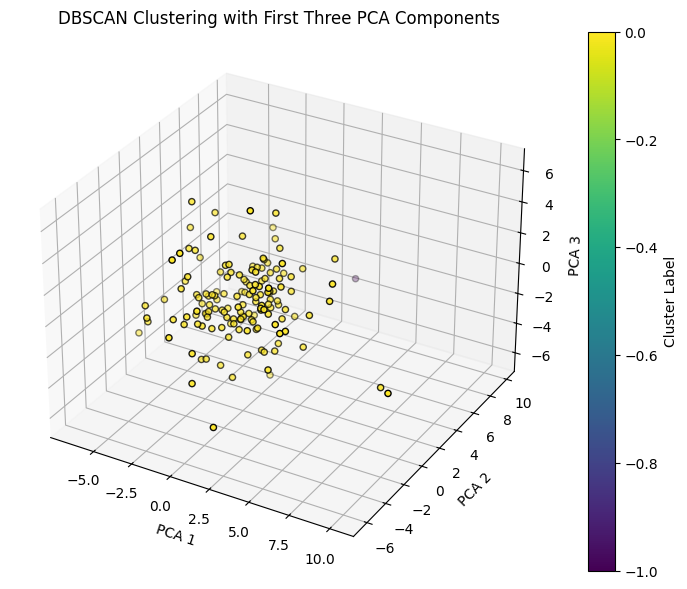

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [105]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN



# Assuming 'X' is your dataset
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Run DBSCAN
dbscan = DBSCAN(eps=6.2, min_samples=2)
clusters = dbscan.fit_predict(X_pca)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('DBSCAN Clustering with First Three PCA Components')

plt.show()

print(clusters)


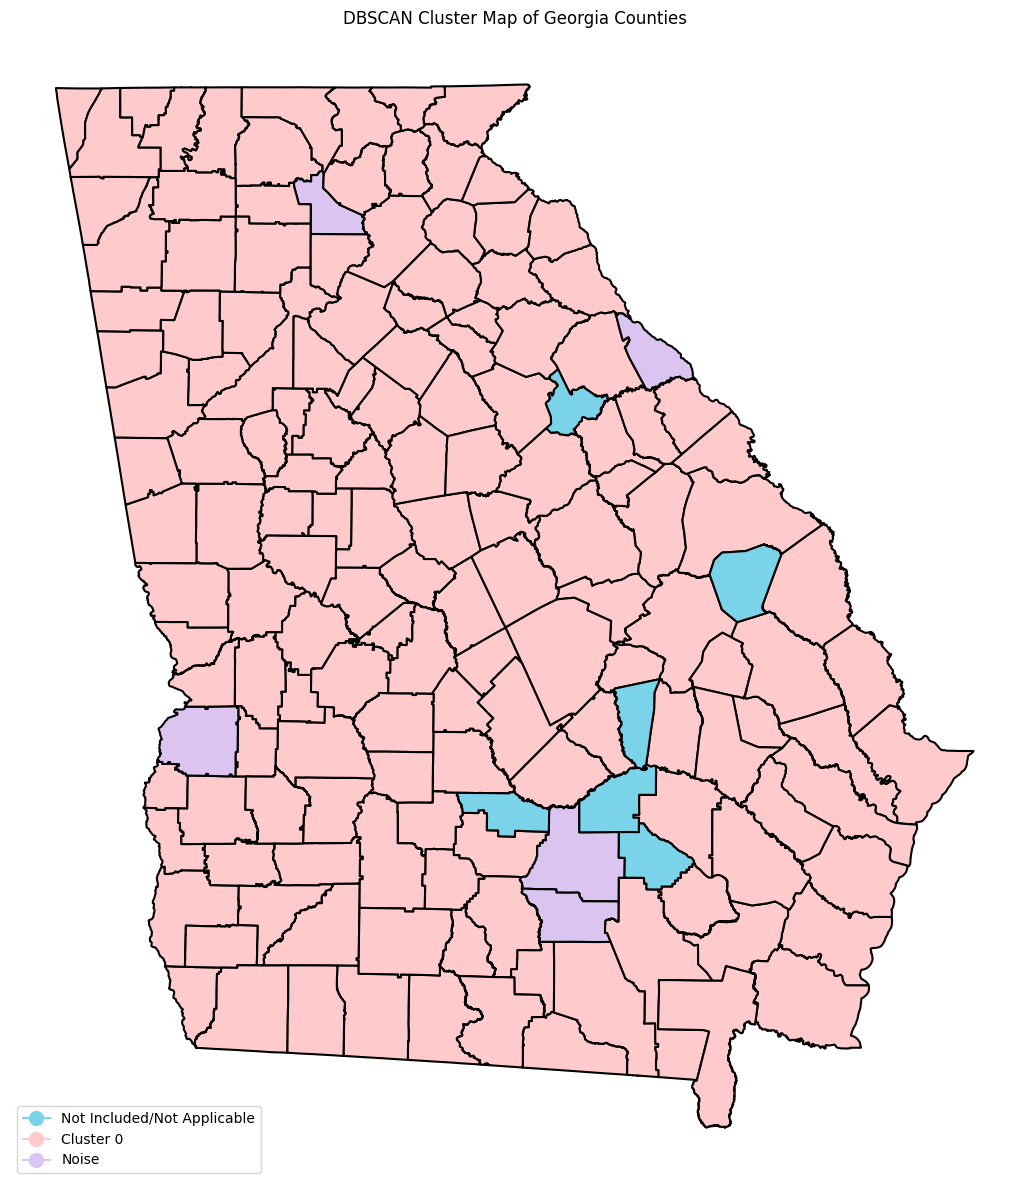

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load the GeoDataFrame of Georgia counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame from the clusters
cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': clusters})

# Merge the geographical data with the cluster data
geo_data = geo_data.merge(cluster_df, how='left', left_on='NAME10', right_on='County')

# Define color mappings for cluster and noise
color_map = {0: '#FFCACC', -1: '#DBC4F0'}  # pink for cluster 0, purple for noise

# Assign colors to counties based on the cluster they belong to
geo_data['color'] = geo_data['Cluster'].apply(lambda x: color_map.get(x, '#7BD3EA'))  # default light blue for counties not in the dataset

# Create manual legend elements for the custom labels
legend_elements = [
    Line2D([0], [0], marker='o', color='#7BD3EA', label='Not Included/Not Applicable', markerfacecolor='#7BD3EA', markersize=10),
    Line2D([0], [0], marker='o', color=color_map[0], label='Cluster 0', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[-1], label='Noise', markerfacecolor=color_map[-1], markersize=10),
]

# Plotting the map with clusters, including thicker borders for the counties
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data.plot(color=geo_data['color'], ax=ax, edgecolor='black', linewidth=1.5)  # Adjust edge color and line width as needed

# Set title and axes properties
ax.set_title('DBSCAN Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


Hierarchical (Agglomerative) Clustering 

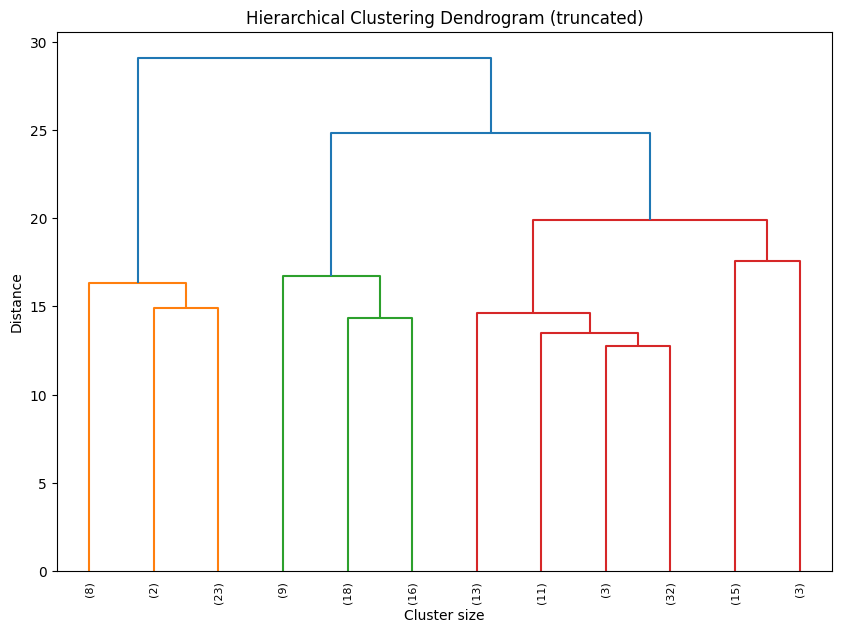

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming 'X' is your dataset
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Perform hierarchical clustering
Z = linkage(X_pca, 'ward')  # 'ward' is one method of calculating distance between clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # This option allows you to truncate the dendrogram to show the last p merged clusters
    p=12,  # showing the last 12 merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')

plt.show()


In [77]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

coefficients_df_cleaned = coefficients_df.dropna()
features_to_scale = coefficients_df_cleaned.columns.drop('County')

# Assuming 'X' is your dataset
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X = X_pca

# Define the parameter range for n_clusters
n_clusters_range = range(2, 10)  # Example: from 2 to 9 clusters

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'n_clusters': None, 'linkage': None}
best_davies_bouldin = {'score': np.inf, 'n_clusters': None, 'linkage': None}
best_calinski_harabasz = {'score': -1, 'n_clusters': None, 'linkage': None}

# Define linkage methods to iterate over
linkage_methods = ['ward', 'complete', 'average', 'single']

# Perform grid search
for n_clusters in n_clusters_range:
    for linkage in linkage_methods:
        # Create and fit the model
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = model.fit_predict(X)
        
        # Calculate metrics
        silhouette = silhouette_score(X, cluster_labels)
        davies_bouldin = davies_bouldin_score(X, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(X, cluster_labels)
        
        # Update best silhouette score
        if silhouette > best_silhouette['score']:
            best_silhouette['score'] = silhouette
            best_silhouette['n_clusters'] = n_clusters
            best_silhouette['linkage'] = linkage
        
        # Update best Davies-Bouldin score (lower is better)
        if davies_bouldin < best_davies_bouldin['score']:
            best_davies_bouldin['score'] = davies_bouldin
            best_davies_bouldin['n_clusters'] = n_clusters
            best_davies_bouldin['linkage'] = linkage
        
        # Update best Calinski-Harabasz score
        if calinski_harabasz > best_calinski_harabasz['score']:
            best_calinski_harabasz['score'] = calinski_harabasz
            best_calinski_harabasz['n_clusters'] = n_clusters
            best_calinski_harabasz['linkage'] = linkage

# Print the best parameters and scores for each metric
print("Silhouette Score:")
print(f"Best Score: {best_silhouette['score']}, n_clusters: {best_silhouette['n_clusters']}, linkage: {best_silhouette['linkage']}")
print("Davies-Bouldin Index:")
print(f"Best Score: {best_davies_bouldin['score']}, n_clusters: {best_davies_bouldin['n_clusters']}, linkage: {best_davies_bouldin['linkage']}")
print("Calinski-Harabasz Index:")
print(f"Best Score: {best_calinski_harabasz['score']}, n_clusters: {best_calinski_harabasz['n_clusters']}, linkage: {best_calinski_harabasz['linkage']}")


Silhouette Score:
Best Score: 0.47302327933798877, n_clusters: 2, linkage: average
Davies-Bouldin Index:
Best Score: 0.37773995887623935, n_clusters: 2, linkage: average
Calinski-Harabasz Index:
Best Score: 24.088593610450747, n_clusters: 2, linkage: ward


[0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 0]


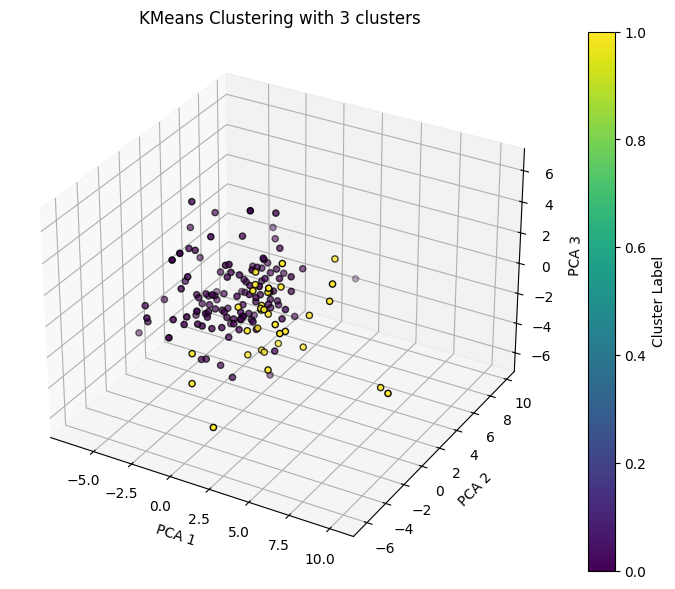

In [99]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming X_pca is your PCA-reduced dataset


# Step 2: Choose the linkage criterion
linkage = 'ward'  # Other options: 'complete', 'average', 'single'

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=2, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 4: Extract cluster labels
cluster_labels = agg_clustering.labels_
print(cluster_labels)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 3 clusters')

plt.show()


In [93]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Assuming 'X_pca' is your PCA-reduced dataset
# Ensure 'X_pca' is defined and contains PCA-reduced features

# Define parameter ranges
linkage_methods = ['ward', 'complete', 'average', 'single']
affinity_methods = ['euclidean', 'manhattan', 'cosine']
distance_thresholds = np.linspace(5.0, 20.0, num=100) 

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'params': None}
best_davies_bouldin = {'score': np.inf, 'params': None}
best_calinski_harabasz = {'score': -1, 'params': None}

for linkage in linkage_methods:
    for affinity in affinity_methods:
        if linkage == 'ward' and affinity != 'euclidean':
            continue  # Ward linkage can only be used with Euclidean distances
        for threshold in distance_thresholds:
            model = AgglomerativeClustering(linkage=linkage, metric=affinity,
                                            n_clusters=None, distance_threshold=threshold,
                                            compute_full_tree=True)
            model.fit(X_pca)
            cluster_labels = model.labels_
            
            # Skip if only one cluster or all points are considered noise
            if len(np.unique(cluster_labels)) < 2 or (np.all(cluster_labels == -1)):
                continue
                
            try:
                silhouette = silhouette_score(X_pca, cluster_labels)
                davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
                calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
            except ValueError:
                continue  # Skip metrics calculation if an error occurs
                
            # Update best silhouette score
            if silhouette > best_silhouette['score']:
                best_silhouette['score'] = silhouette
                best_silhouette['params'] = (linkage, affinity, threshold)
                
            # Update best Davies-Bouldin score (lower is better)
            if davies_bouldin < best_davies_bouldin['score']:
                best_davies_bouldin['score'] = davies_bouldin
                best_davies_bouldin['params'] = (linkage, affinity, threshold)
                
            # Update best Calinski-Harabasz score
            if calinski_harabasz > best_calinski_harabasz['score']:
                best_calinski_harabasz['score'] = calinski_harabasz
                best_calinski_harabasz['params'] = (linkage, affinity, threshold)

# Print the best parameters and scores for each metric
print("Best Silhouette Score:", best_silhouette['score'], "Parameters:", best_silhouette['params'])
print("Best Davies-Bouldin Score:", best_davies_bouldin['score'], "Parameters:", best_davies_bouldin['params'])
print("Best Calinski-Harabasz Score:", best_calinski_harabasz['score'], "Parameters:", best_calinski_harabasz['params'])


Best Silhouette Score: 0.47302327933798877 Parameters: ('average', 'euclidean', 11.06060606060606)
Best Davies-Bouldin Score: 0.37773995887623935 Parameters: ('average', 'euclidean', 11.06060606060606)
Best Calinski-Harabasz Score: 23.389803205198692 Parameters: ('ward', 'euclidean', 20.0)


[0 1 2 0 1 0 1 0 1 0 2 1 2 1 0 0 0 2 2 1 0 2 1 2 1 2 0 0 0 1 0 1 0 2 0 0 2
 1 0 0 0 1 0 1 0 0 0 0 2 2 2 0 2 2 0 0 0 0 0 0 0 0 1 1 0 2 1 1 2 2 0 2 0 0
 2 1 0 0 2 2 0 0 1 0 2 2 2 0 0 0 0 0 1 0 1 0 1 2 2 1 0 0 2 2 0 2 2 0 2 0 0
 2 0 0 1 2 1 0 1 0 0 0 0 0 0 0 0 1 0 2 0 0 2 2 0 0 1 2 1 0 0 2 1 1 2 2 0 2
 1 0 2 0 0]


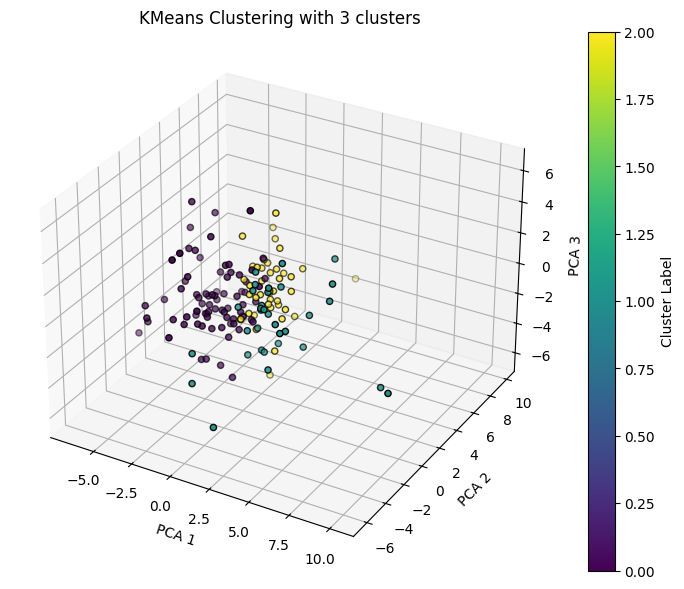

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [104]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming X_pca is your PCA-reduced dataset


# Step 2: Choose the linkage criterion
linkage = 'ward'  # Other options: 'complete', 'average', 'single'

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, metric="euclidean", distance_threshold=20, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 4: Extract cluster labels
cluster_labels = agg_clustering.labels_
print(cluster_labels)


from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 3 clusters')

plt.show()



from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming X_pca is your PCA-reduced dataset


# Step 2: Choose the linkage criterion
linkage = 'average'  # Other options: 'complete', 'average', 'single'

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, metric="euclidean", distance_threshold=11.06, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 4: Extract cluster labels
cluster_labels = agg_clustering.labels_
print(cluster_labels)